In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moment
from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq
from scipy import signal

In [2]:
ecg = pd.read_csv("with50hzfilterlargeelectrodes.csv", nrows = 100000, skiprows = [i for i in range(2,1000)])
ecg

,MSP432 ADC Data with 46Hz low pass filter,50filtered(voltage),Unnamed: 2,This data was taken on abraded skin using the Large electrodes with saltwater solution
0,7212,1.452701,NaN,NaN
1,9474,1.908332,NaN,NaN
2,9520,1.917598,NaN,NaN
3,9611,1.935927,NaN,NaN
4,9717,1.957279,NaN,NaN
...,...,...,...,...
99995,9577,1.929079,NaN,NaN
99996,9605,1.934719,NaN,NaN
99997,9655,1.944790,NaN,NaN
99998,9685,1.950833,NaN,NaN


In [3]:
voltage = np.array(ecg["50filtered(voltage)"])
type(voltage)
len(voltage)

100000

In [5]:
voltage

array([1.45270097, 1.90833181, 1.91759751, ..., 1.94479033, 1.95083318,
       1.95768174])

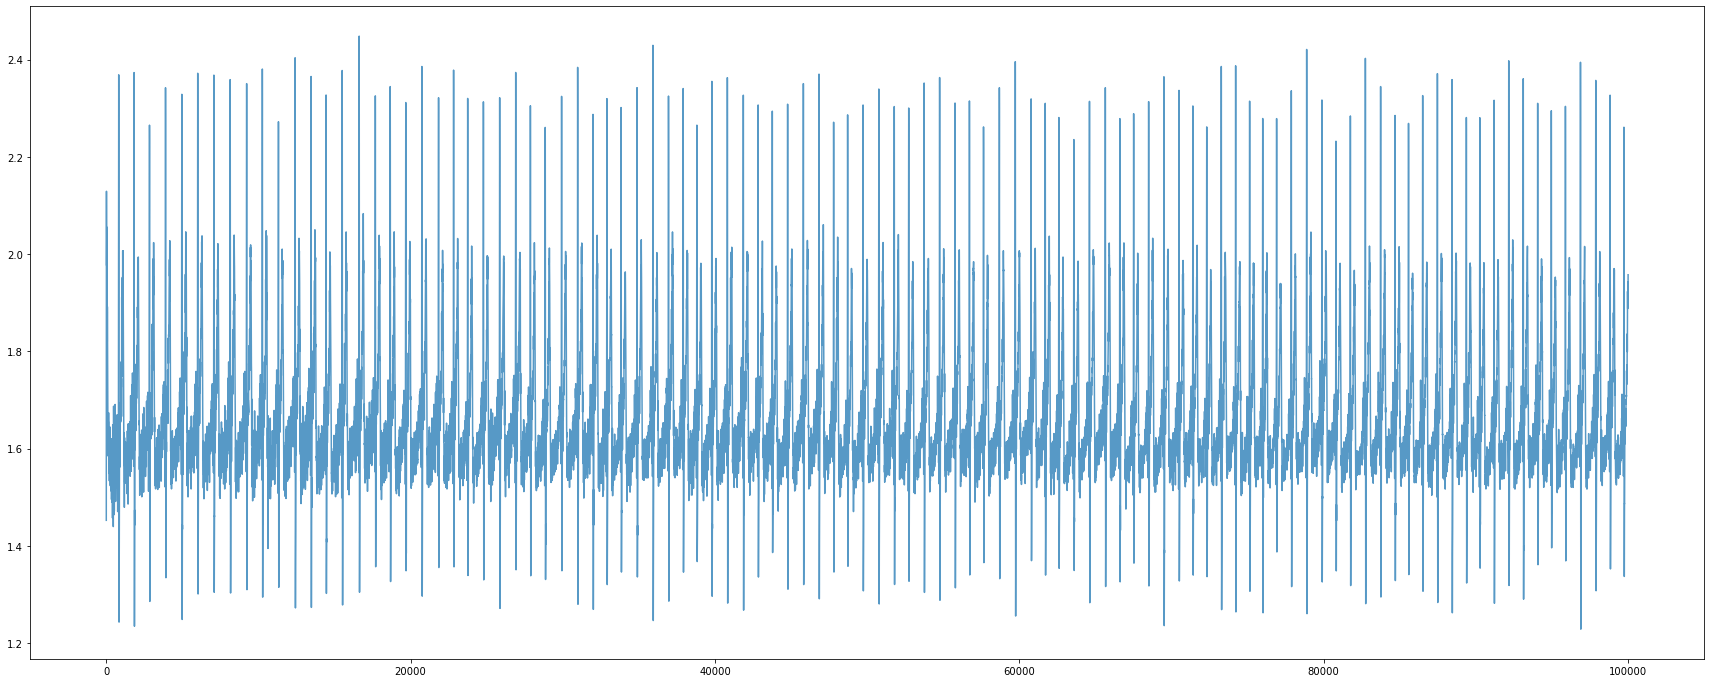

In [6]:
plt.figure(figsize=(30,12))
plt.plot(voltage, alpha=0.75)

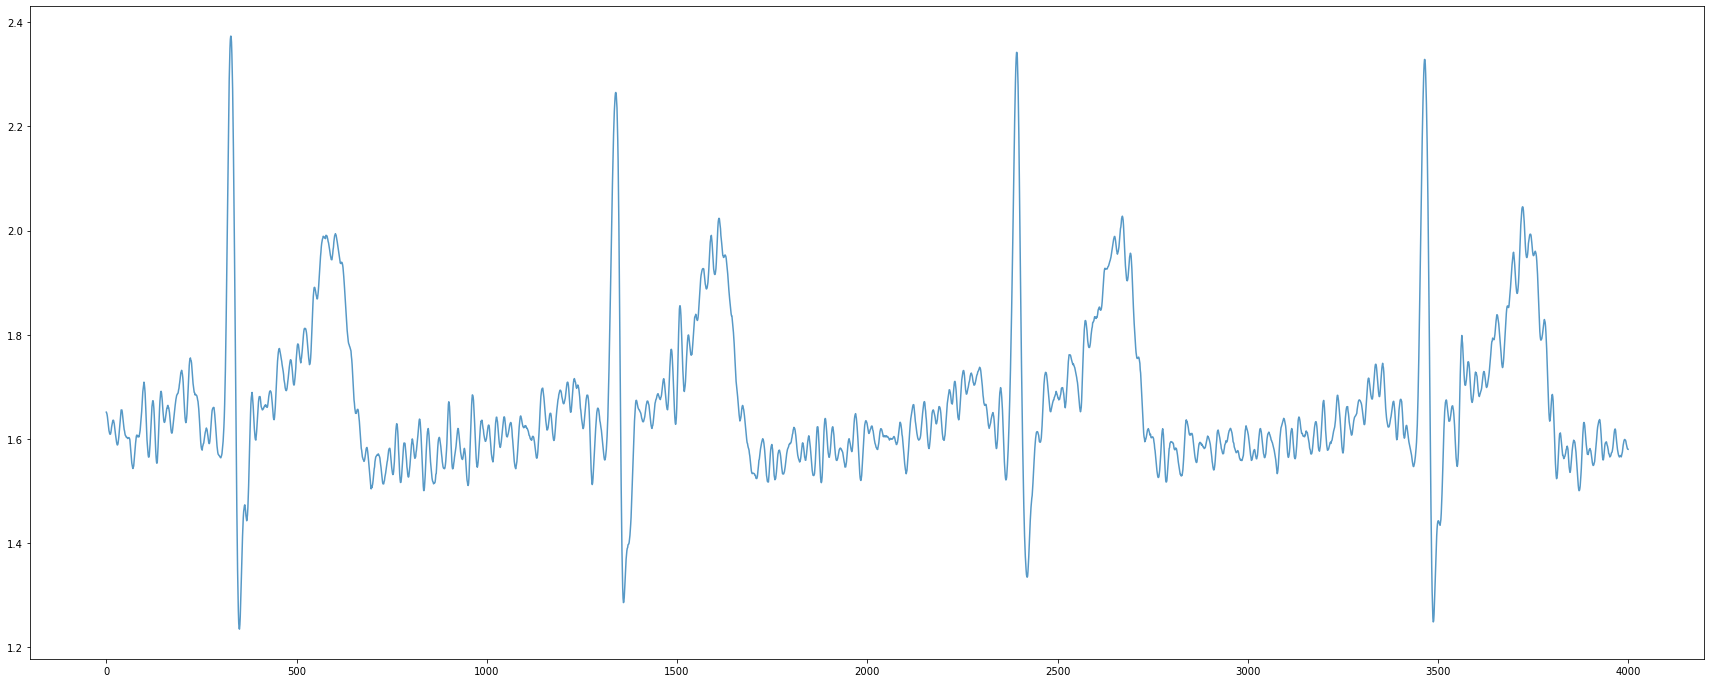

In [9]:
plt.figure(figsize=(30,12))
plt.plot(voltage[1500:5500], alpha=0.75)

In [7]:
len(voltage)

100000

In [8]:
# Visualise frequencies present in the signal with FFT
N = 3100 # number of samples

yf = fft(voltage[100:],n=N,axis=0)
xf = fftfreq(N, 1/1000)

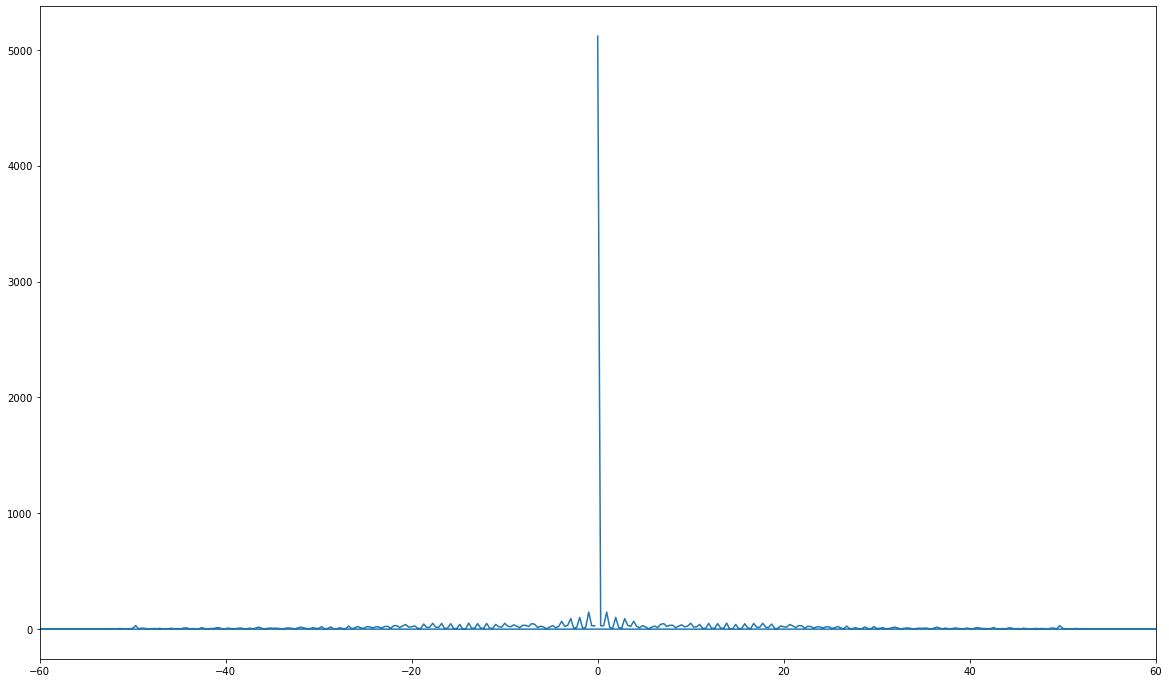

In [9]:
plt.figure(figsize=(20,12))
plt.plot(xf, np.abs(yf))
plt.xlim(xmin=-60,xmax=60) 
plt.show()

# Step 1 - Replicate an analog hardware filter

Study 1 (from slides) band-pass filtered the ECG between 0.05 and 35Hz with analog hardware filters.

#### Digital Butterworth filter

In [12]:
# Construct butterworth signal filter
b, a = signal.butter(10, 35, fs=1000, btype="low", output='ba') # what order would an analog filter be??
# Apply lowpass filter
voltage_filtered = signal.lfilter(b,a,voltage)

In [13]:
b

array([1.32941973e-10, 1.32941973e-09, 5.98238877e-09, 1.59530367e-08,
       2.79178143e-08, 3.35013771e-08, 2.79178143e-08, 1.59530367e-08,
       5.98238877e-09, 1.32941973e-09, 1.32941973e-10])

In [14]:
a

array([   1.        ,   -8.59441517,   33.32589792,  -76.7693579 ,
        116.3321643 , -121.15676597,   87.81840166,  -43.74030877,
         14.32610813,   -2.78598943,    0.24426537])

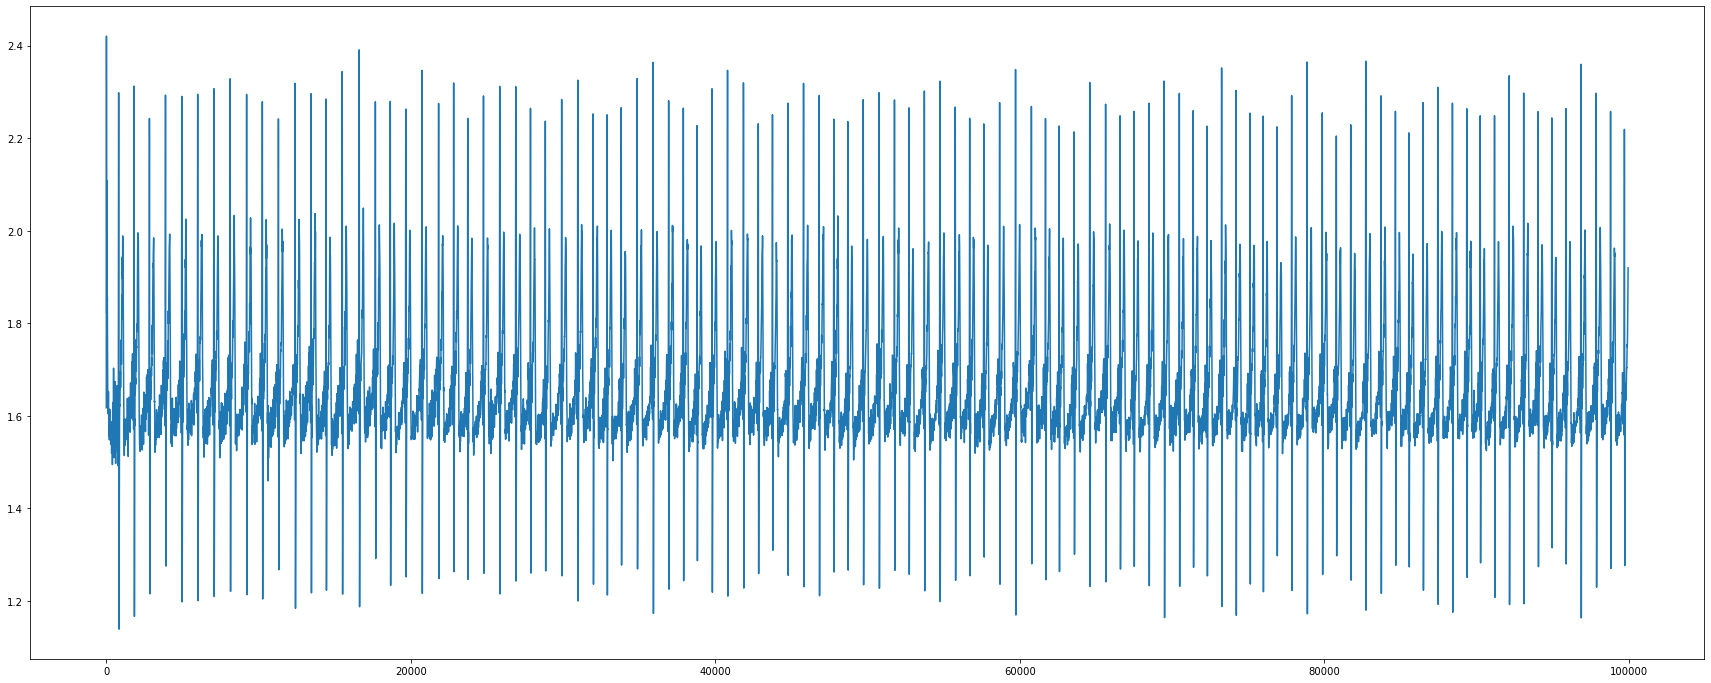

In [15]:
plt.figure(figsize=(30,12))
plt.plot(voltage_filtered[35:])

In [16]:
voltage_filtered

array([1.93124933e-10, 3.84474258e-09, 3.80897772e-08, ...,
       1.91482978e+00, 1.91763175e+00, 1.91990756e+00])

# Step 2 - ECG-derived respiration

## 2.1. Band-pass filter to reduce high frequency distortions and muscle noise

Use a 3rd order elliptic low-pass filter with a 45Hz upper cutoff and a 4th order elliptic high-pass filter with a 0.5Hz lower cut-off

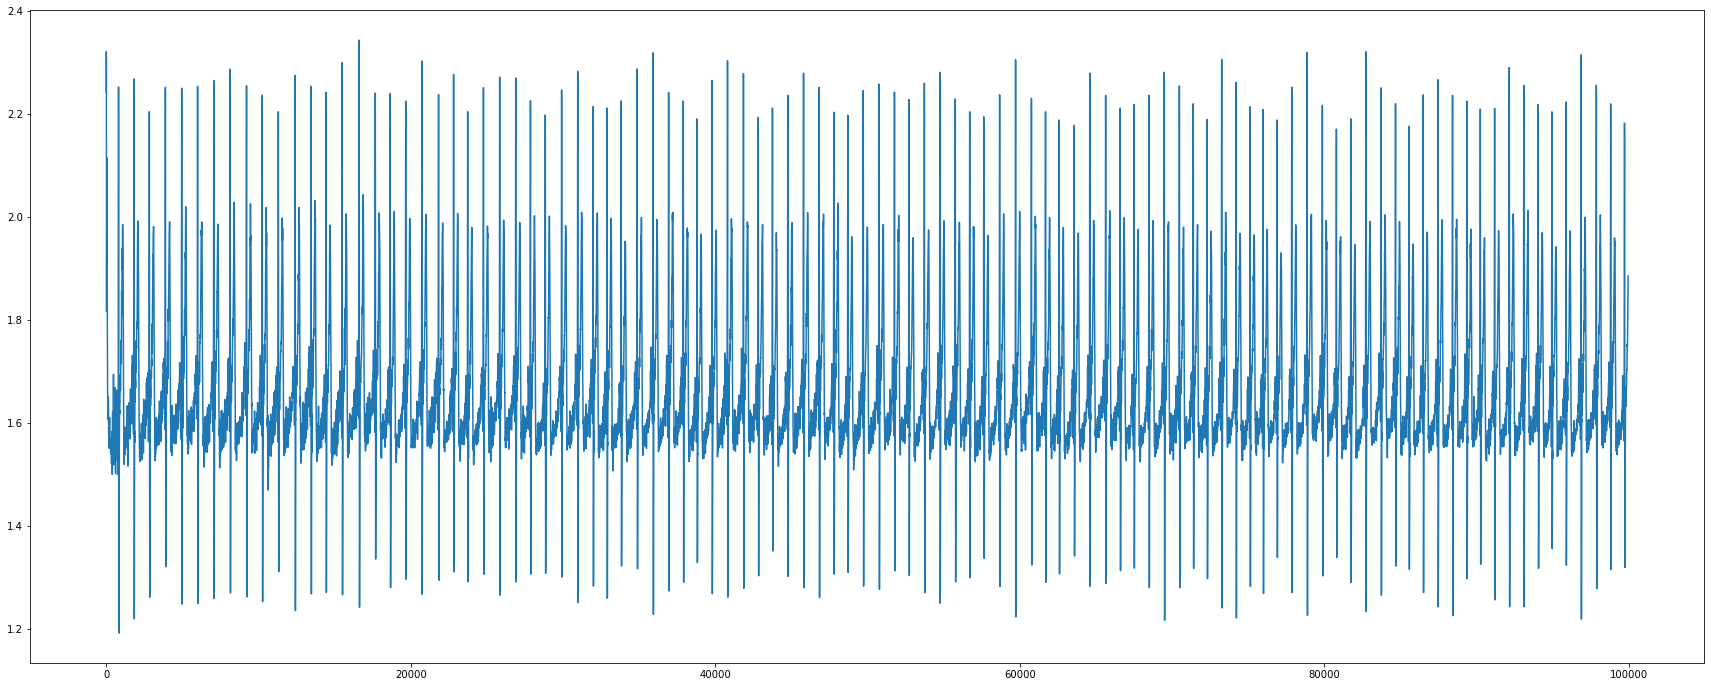

In [17]:
# Construct 3rd order Cauer elliptical low-pass filter
max_ripple = 1
min_attenuation = 60
b, a = signal.ellip(3, max_ripple, min_attenuation, 45, fs=1000, btype='low')
# Apply filter
cauer_low_filtered = signal.lfilter(b,a,voltage_filtered)
# Plot filtered signal
plt.figure(figsize=(30,12))
plt.plot(cauer_low_filtered[50:])

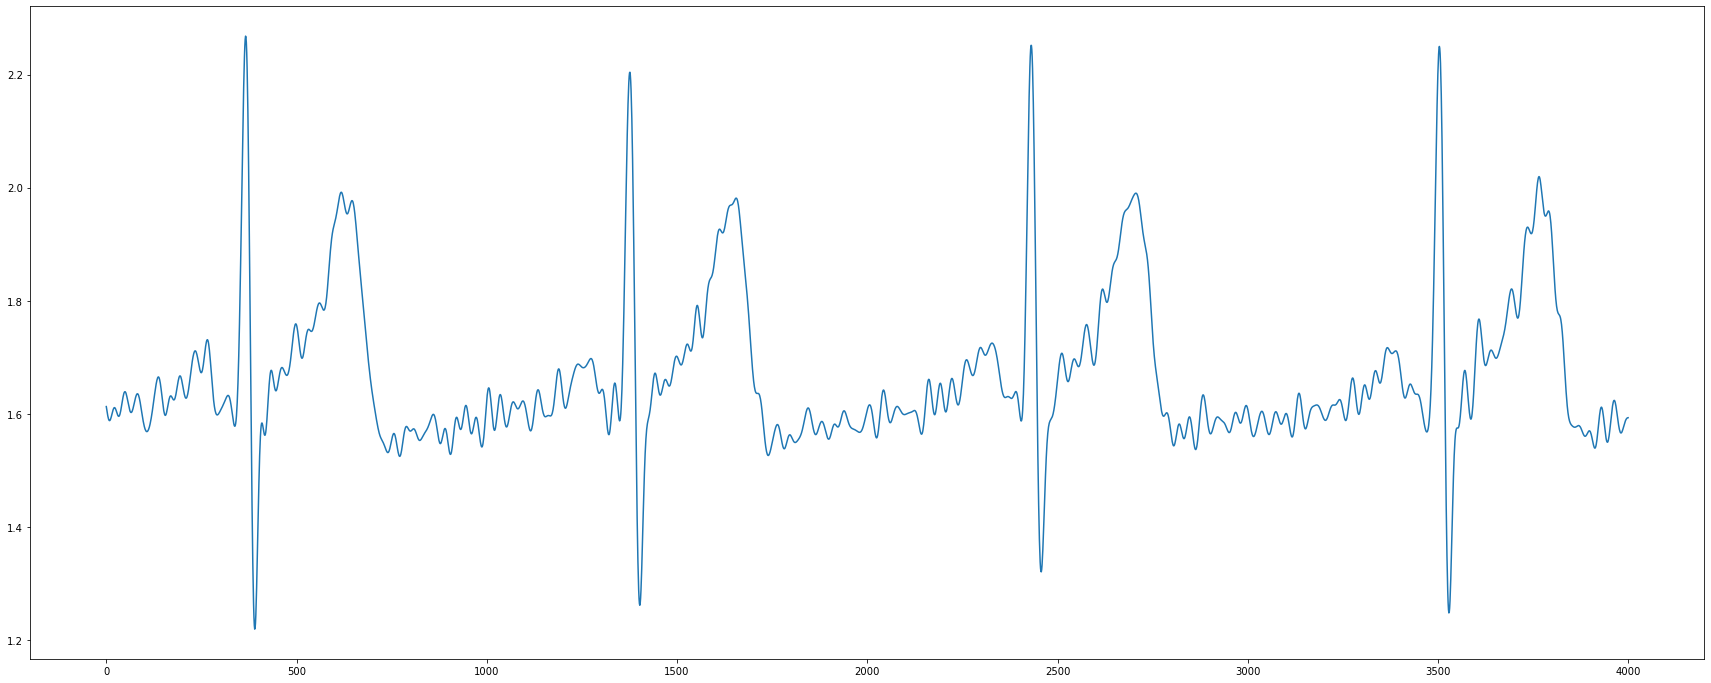

In [18]:
plt.figure(figsize=(30,12))
plt.plot(cauer_low_filtered[1500:5500])

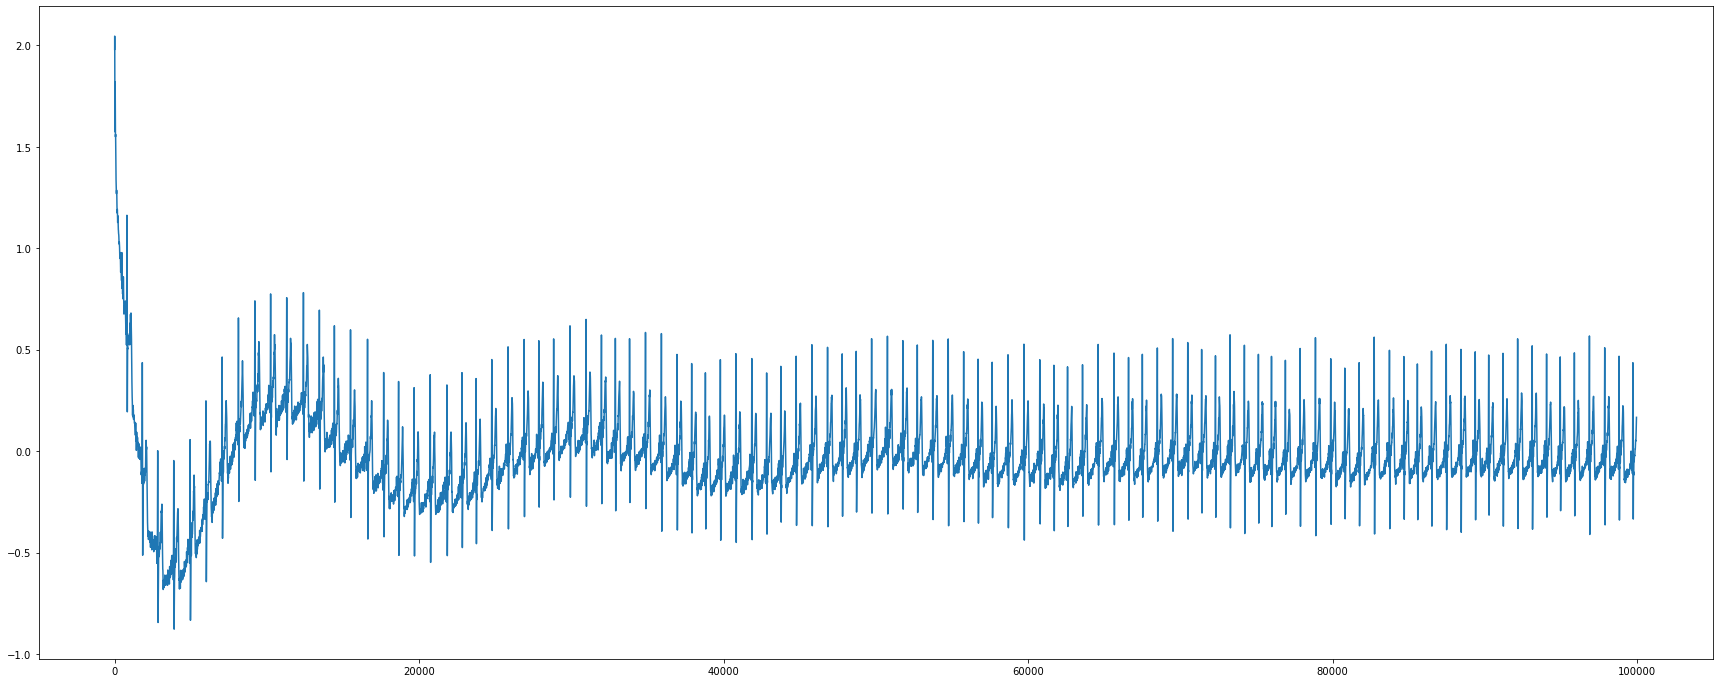

In [23]:
# Construct 4th order Cauer elliptical high-pass filter
max_ripple = 1
min_attenuation = 60
b, a = signal.ellip(4, max_ripple, min_attenuation, 0.05, fs=1000, btype='high')
# Apply filter
cauer_high_filtered = signal.lfilter(b,a, cauer_low_filtered)
# Plot filtered signal
plt.figure(figsize=(30,12))
plt.plot(cauer_high_filtered[50:])

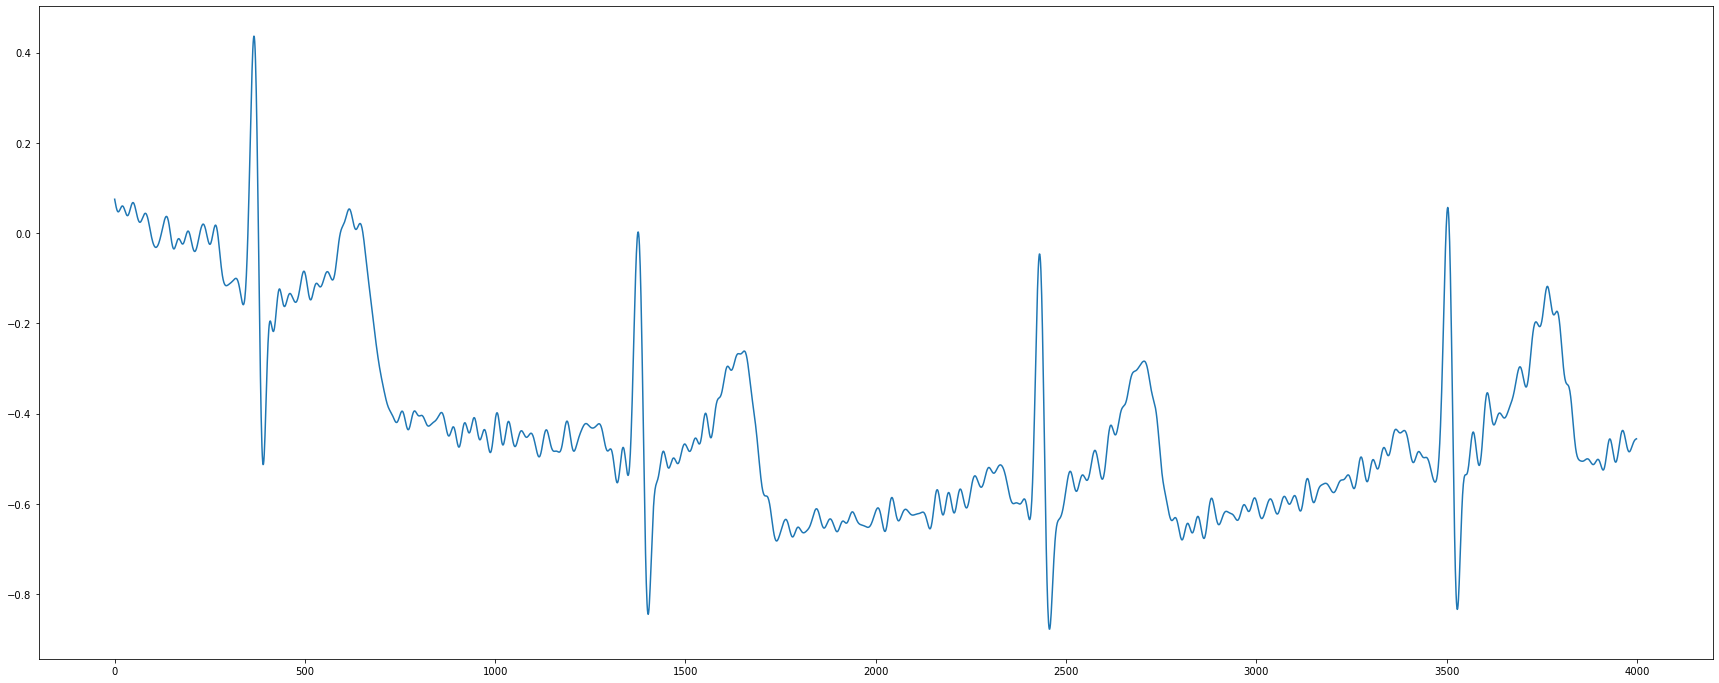

In [21]:
plt.figure(figsize=(30,12))
plt.plot(cauer_high_filtered[1500:5500])

No need for a high pass filter? Or maybe design it differently so it doesn't mess up the baseline? 

## 2.2. Remove baseline wander

The baseline is estimated by median-filtering the ECG:
- a first (200 ms long) median filter removes QRS-complexes and P-waves from the ECG

- a second (600 ms long) median filter eliminates T-waves from the ECG.

The remaining signal is considered baseline and subtracted from the ECG to remove baseline wander.

In [24]:
# 200ms median filter
baseline1 = signal.medfilt(cauer_low_filtered,199)
baseline1[50:100]

array([1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313,
       1.65619313, 1.65619313, 1.65619313, 1.65619313, 1.65619313])

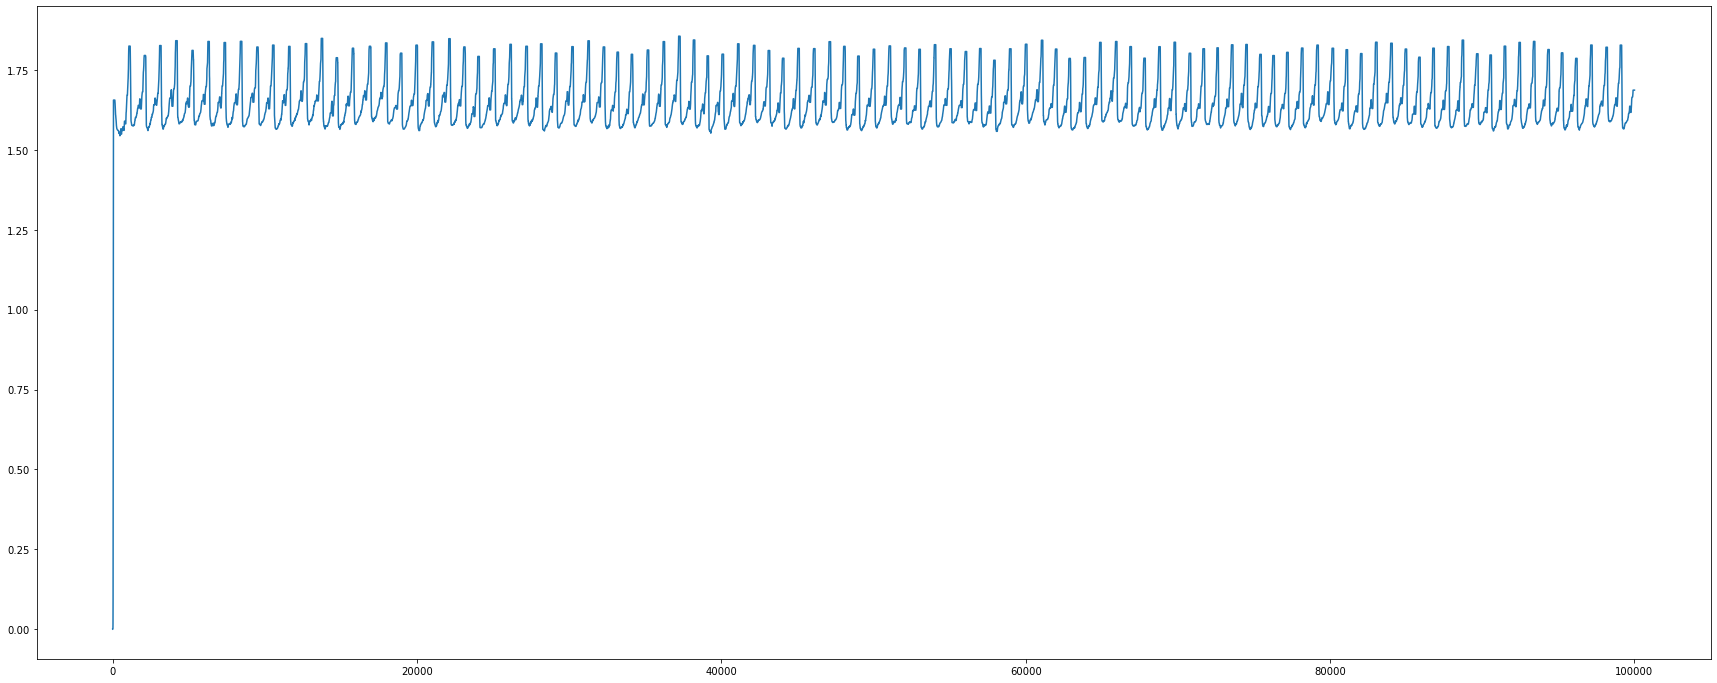

In [25]:
# Plot baseline
plt.figure(figsize=(30,12))
plt.plot(baseline1)

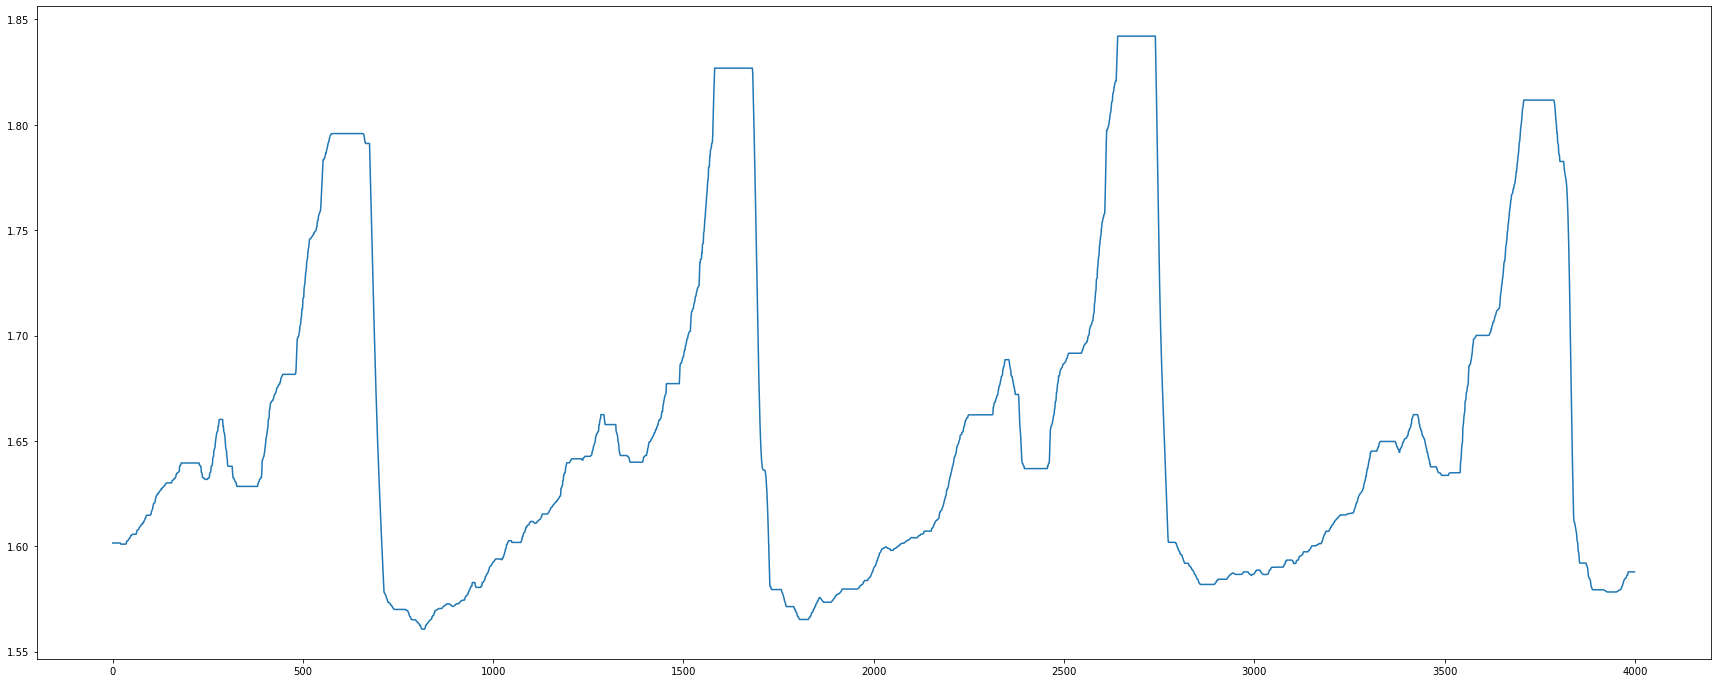

In [26]:
# Plot baseline section for report
plt.figure(figsize=(30,12))
plt.plot(baseline1[1500:5500])

In [28]:
#600ms median filter
baseline2 = signal.medfilt(baseline1, 599)
baseline2[50:100]

array([1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435,
       1.56143435, 1.56143435, 1.56143435, 1.56143435, 1.56143435])

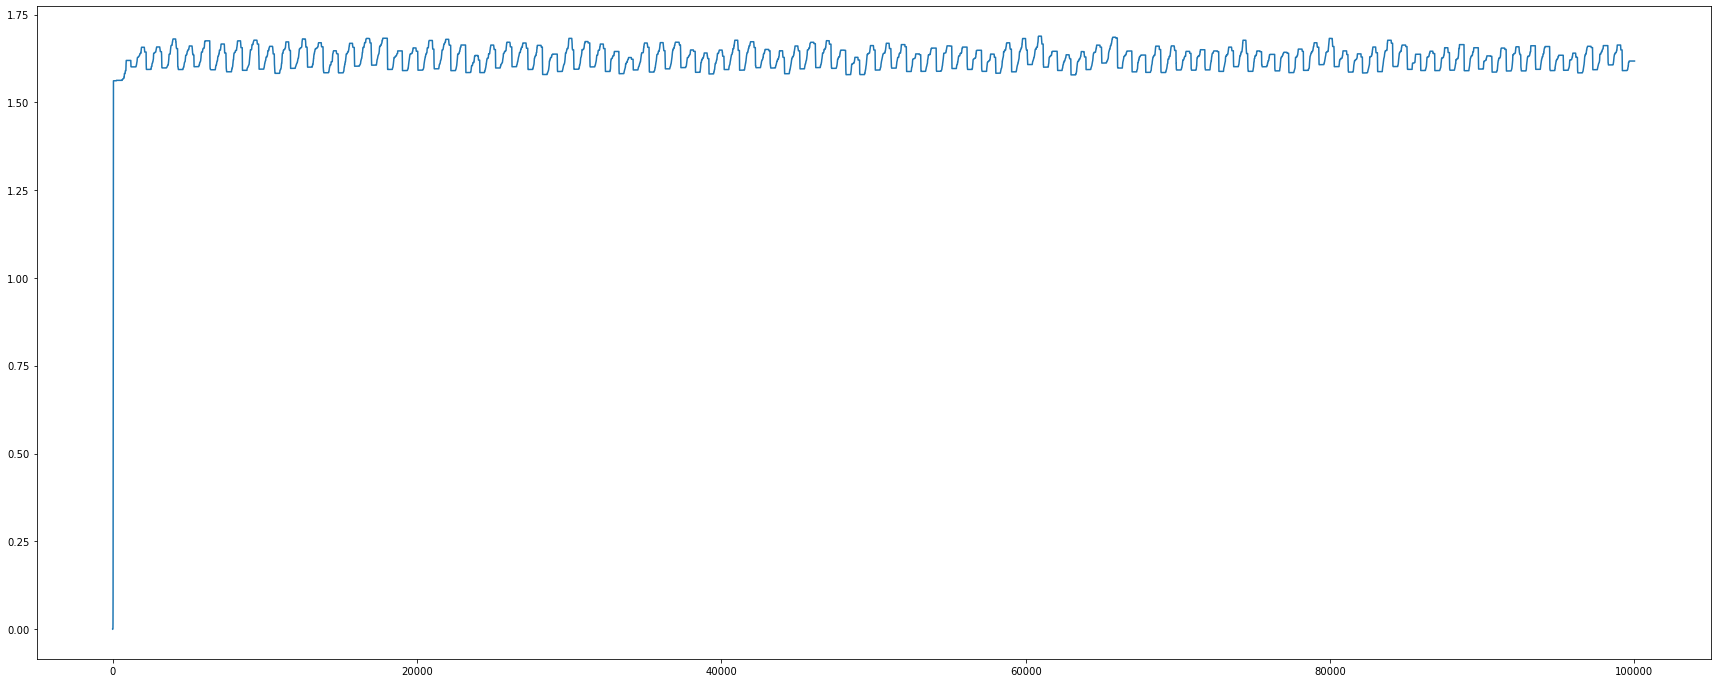

In [29]:
# Plot baseline
plt.figure(figsize=(30,12))
plt.plot(baseline2)

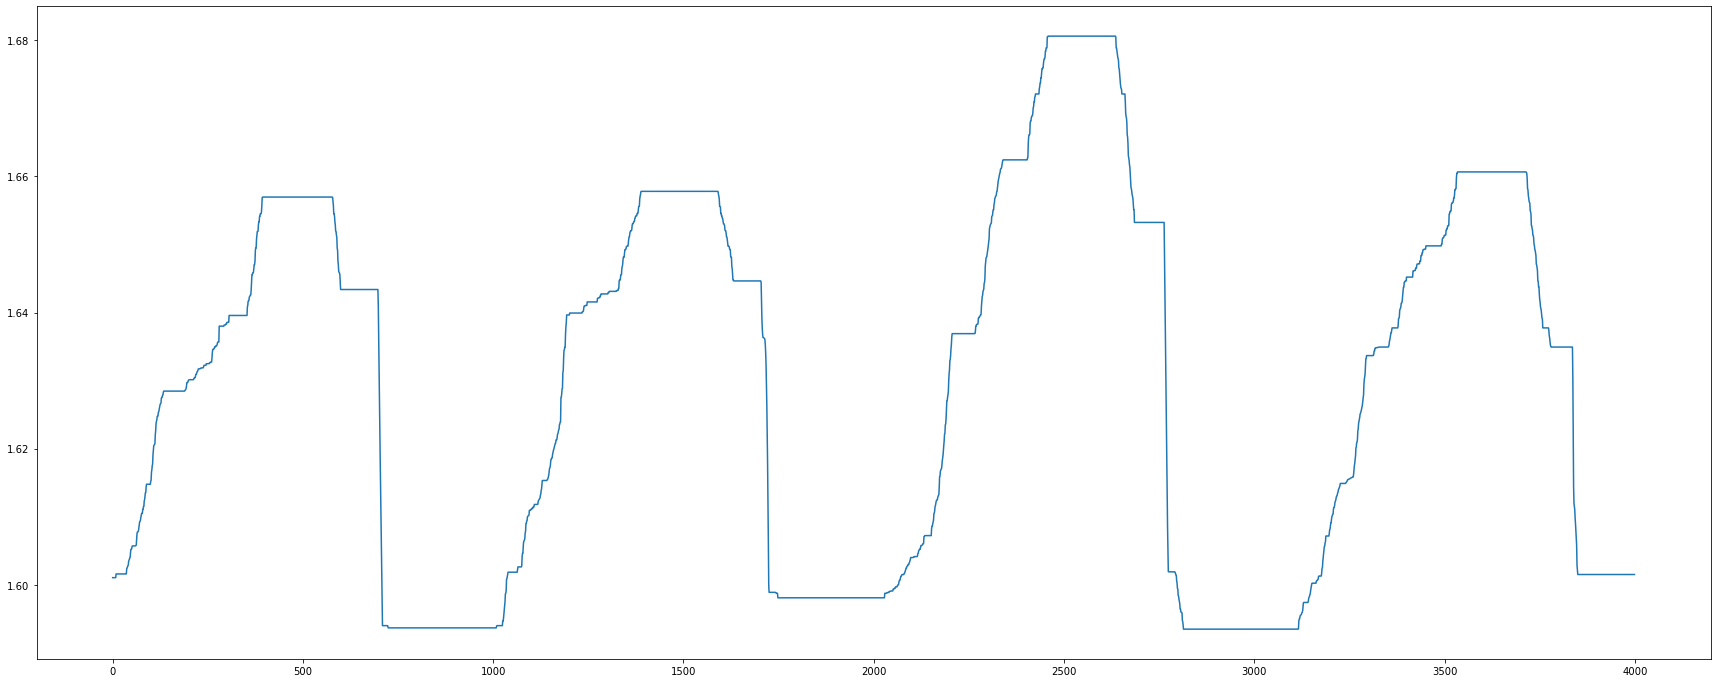

In [30]:
# Plot baseline section for report
plt.figure(figsize=(30,12))
plt.plot(baseline2[1500:5500])

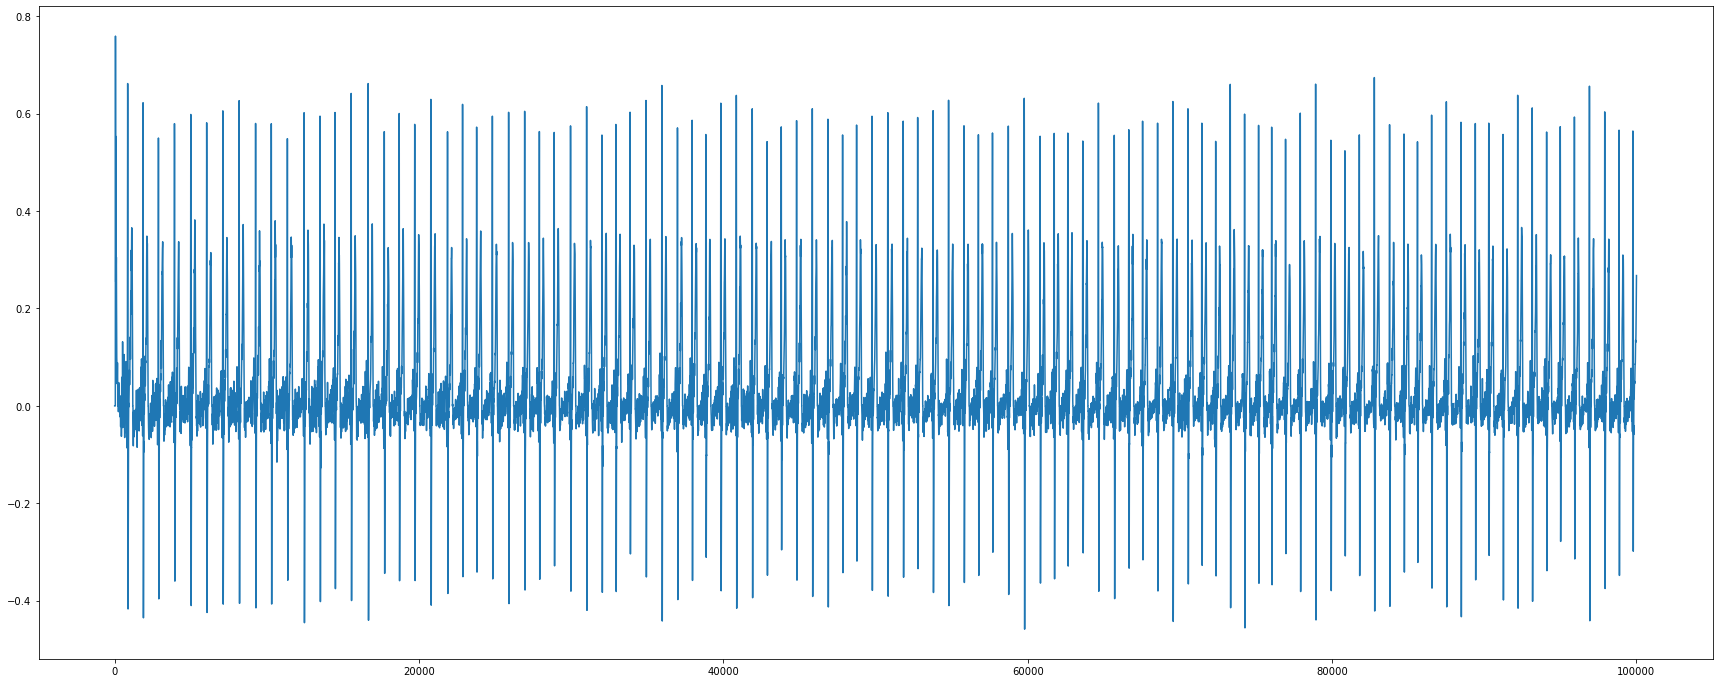

In [32]:
# Subtract baseline from ECG
clean_ecg = cauer_low_filtered - baseline2
plt.figure(figsize=(30,12))
plt.plot(clean_ecg)

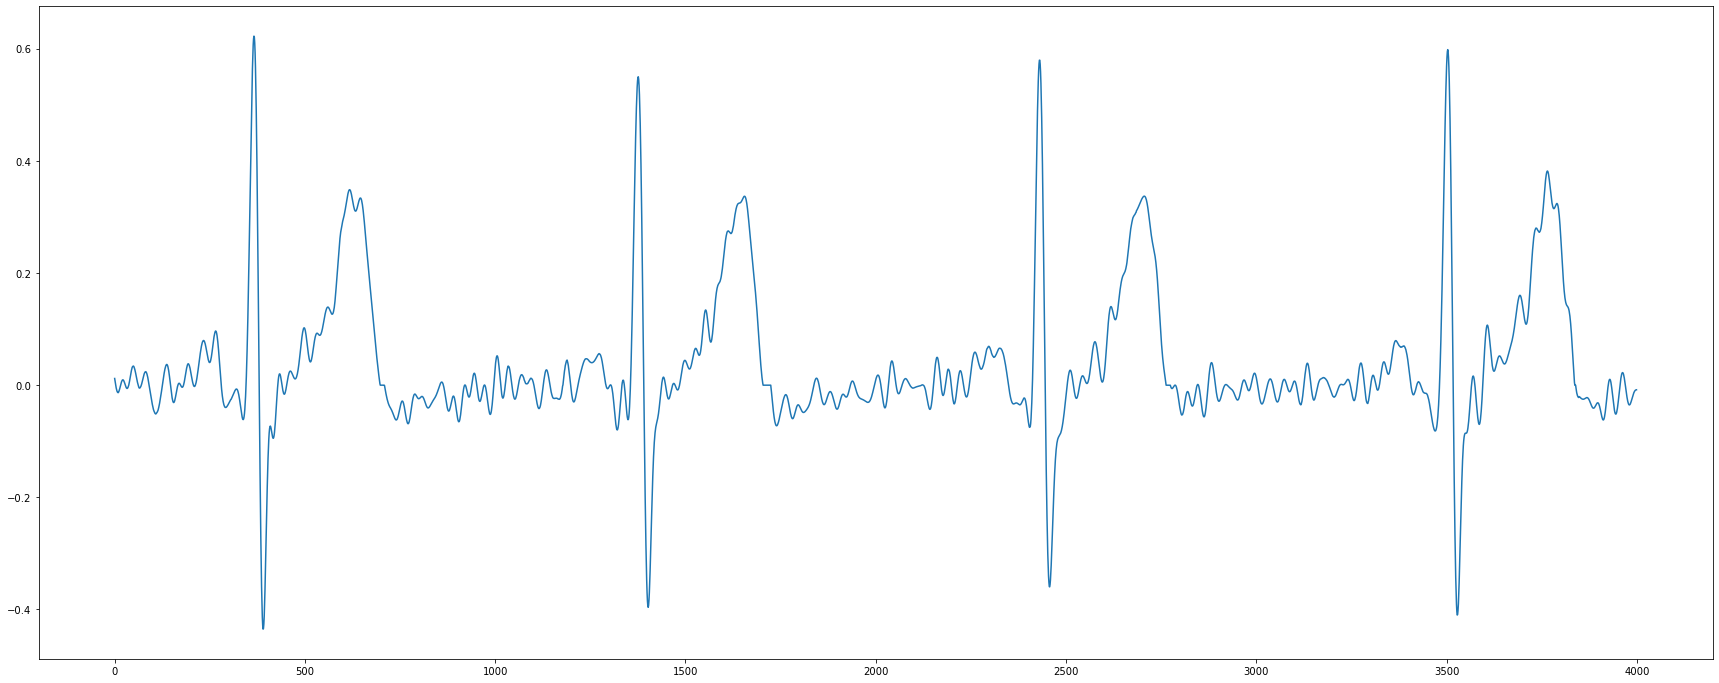

In [33]:
plt.figure(figsize=(30,12))
plt.plot(clean_ecg[1500:5500])

## 2.3. Calculate 4th Central Moments

4th order central moments calculated in a sliding window of 200 ms and a step width of 5 ms



In [103]:
# Create sliding window view with window size 200 and step size 5ms
v = np.lib.stride_tricks.sliding_window_view(clean_ecg, 200)#[::5,:]
v

array([[ 0.        ,  0.        ,  0.        , ...,  0.0517685 ,
         0.04645816,  0.0410058 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.04645816,
         0.0410058 ,  0.0355038 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0410058 ,
         0.0355038 ,  0.03005361],
       ...,
       [-0.13331147, -0.11268405, -0.09415328, ...,  0.24915783,
         0.25358599,  0.25817589],
       [-0.11268405, -0.09415328, -0.0781245 , ...,  0.25358599,
         0.25817589,  0.26288038],
       [-0.09415328, -0.0781245 , -0.06486248, ...,  0.25817589,
         0.26288038,  0.26763807]])

In [104]:
v.shape

(99801, 200)

In [ ]:
print(v[200])

In [106]:
len(v)

99801

In [107]:
moments = [];
for i in range(0, len(v)):
    m = moment(v[i], moment=4)
    moments.append(m)

In [108]:
print(moments[200])

5.563181652332302e-07


In [109]:
len(moments)

99801

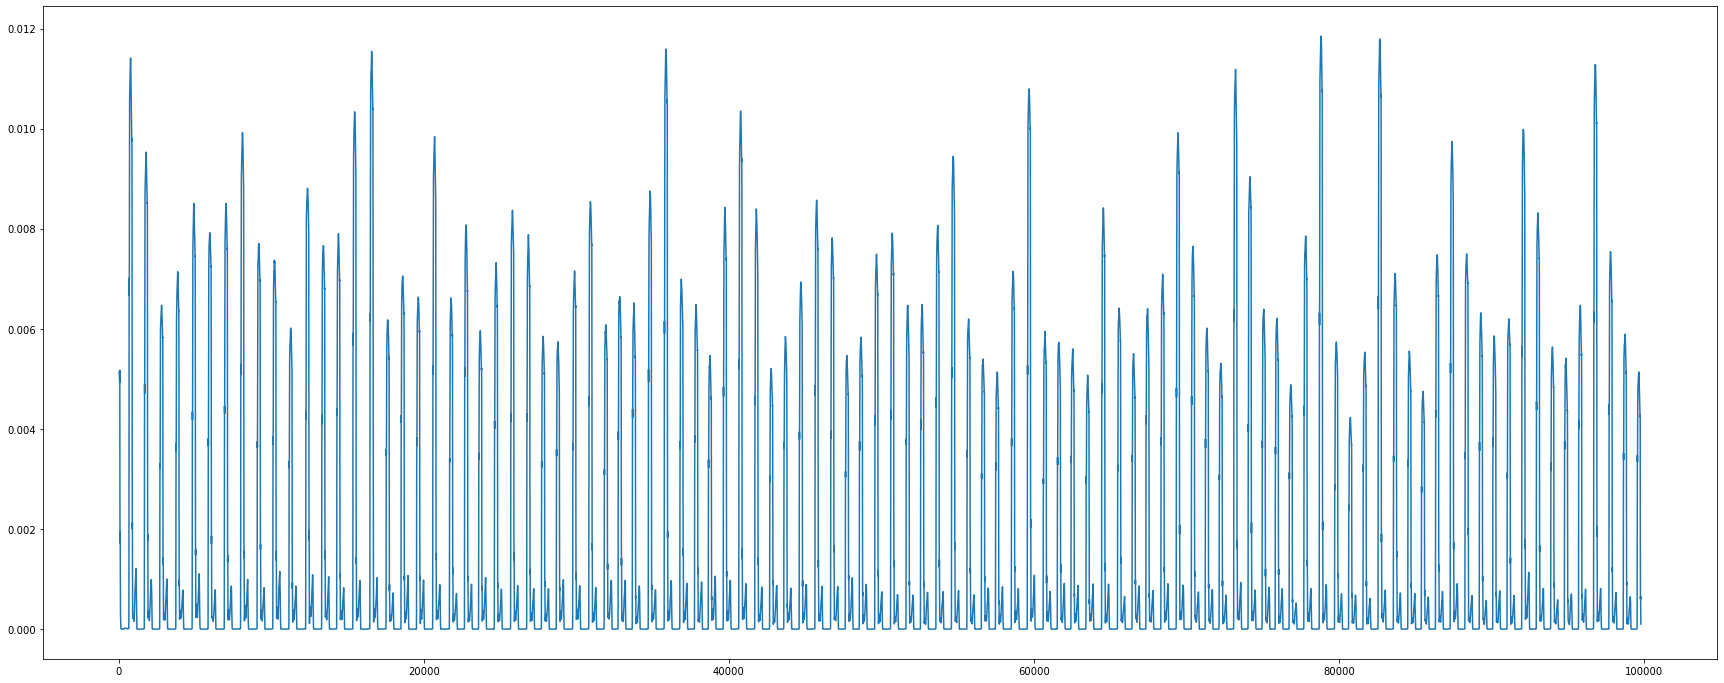

In [110]:
plt.figure(figsize=(30,12))
plt.plot(moments)

In [111]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

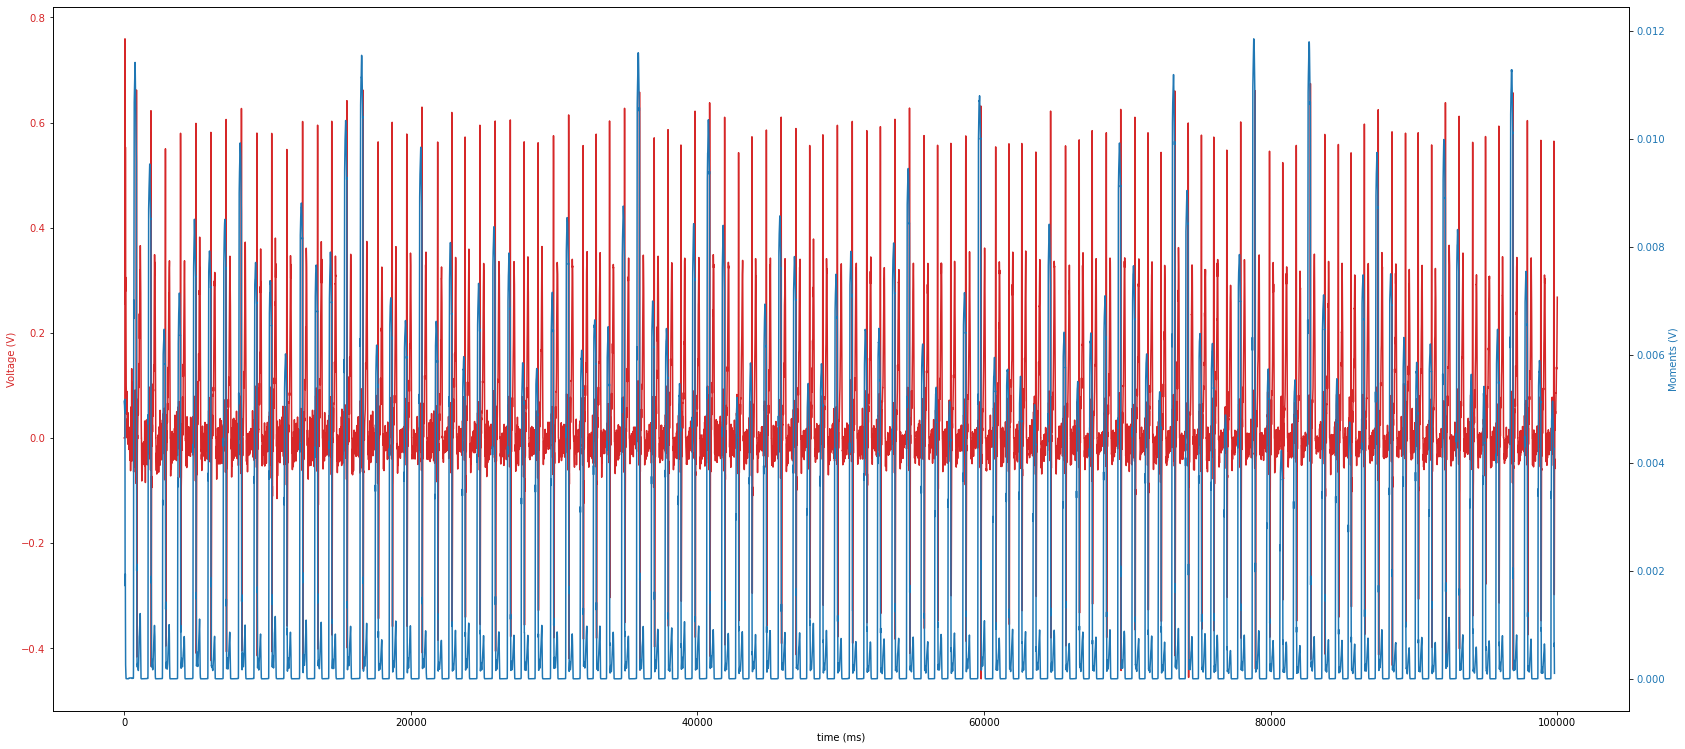

In [112]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('Voltage (V)', color=color)
clean_ecg_short_plot = clean_ecg
# for i in range(100,len(clean_ecg)):
#     clean_ecg_short_plot.append(clean_ecg[i])
    
ax1.plot(clean_ecg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Moments (V)', color=color)  # we already handled the x-label with ax1
ax2.plot(moments, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figwidth(30)
fig.set_figheight(12)
plt.show()
#plt.savefig("clean_ecg_with_moments.png")

# Getting the peak moments

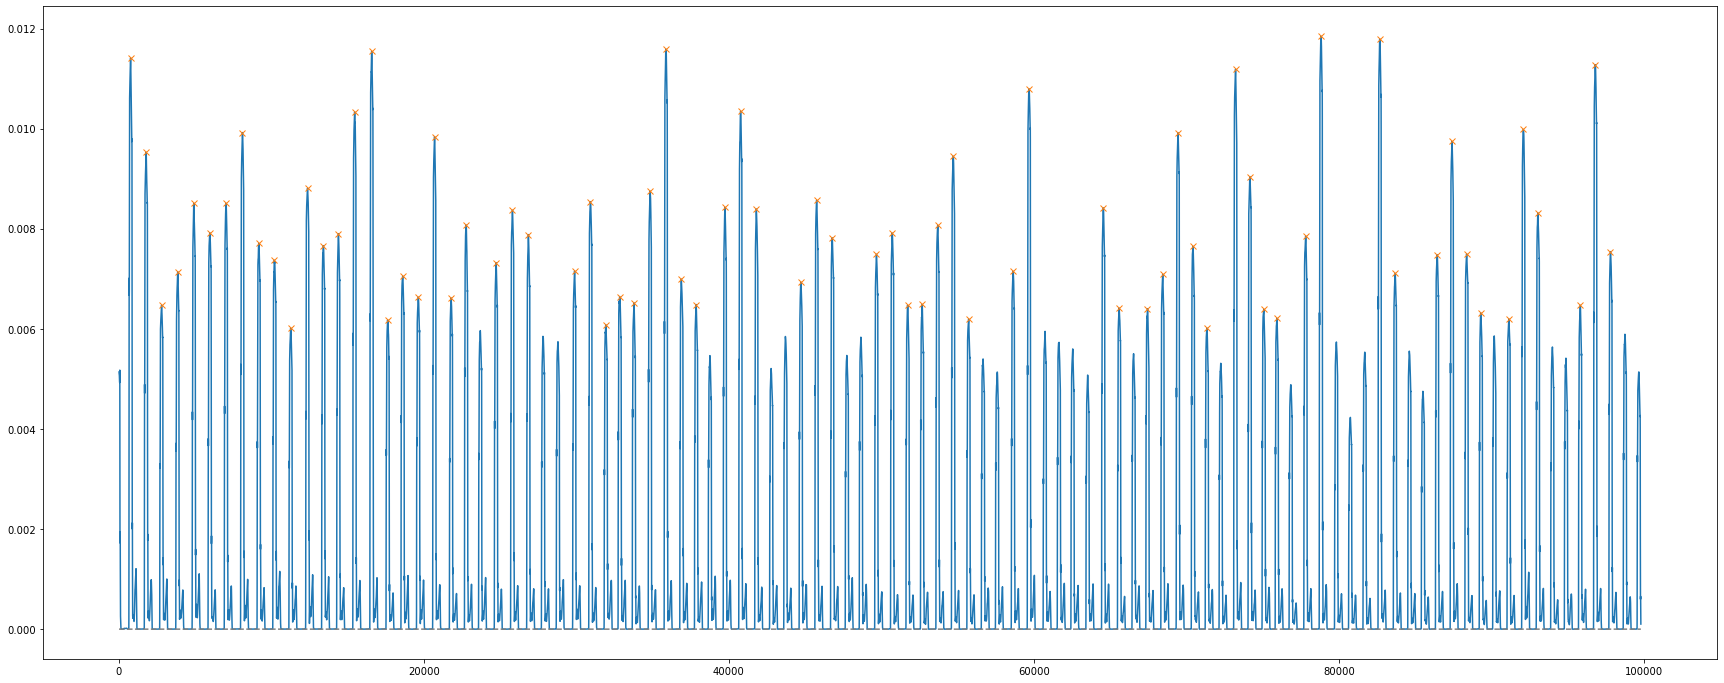

In [114]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
x = np.array(moments)
peaks, _ = find_peaks(x, height=0.006, distance = 150)
plt.figure(figsize=(30,12))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [116]:
peakdata = []; 
for i in range(0,len(peaks)):
    peakdata.append(moments[peaks[i]])

## Creating a cubic spline of peak data

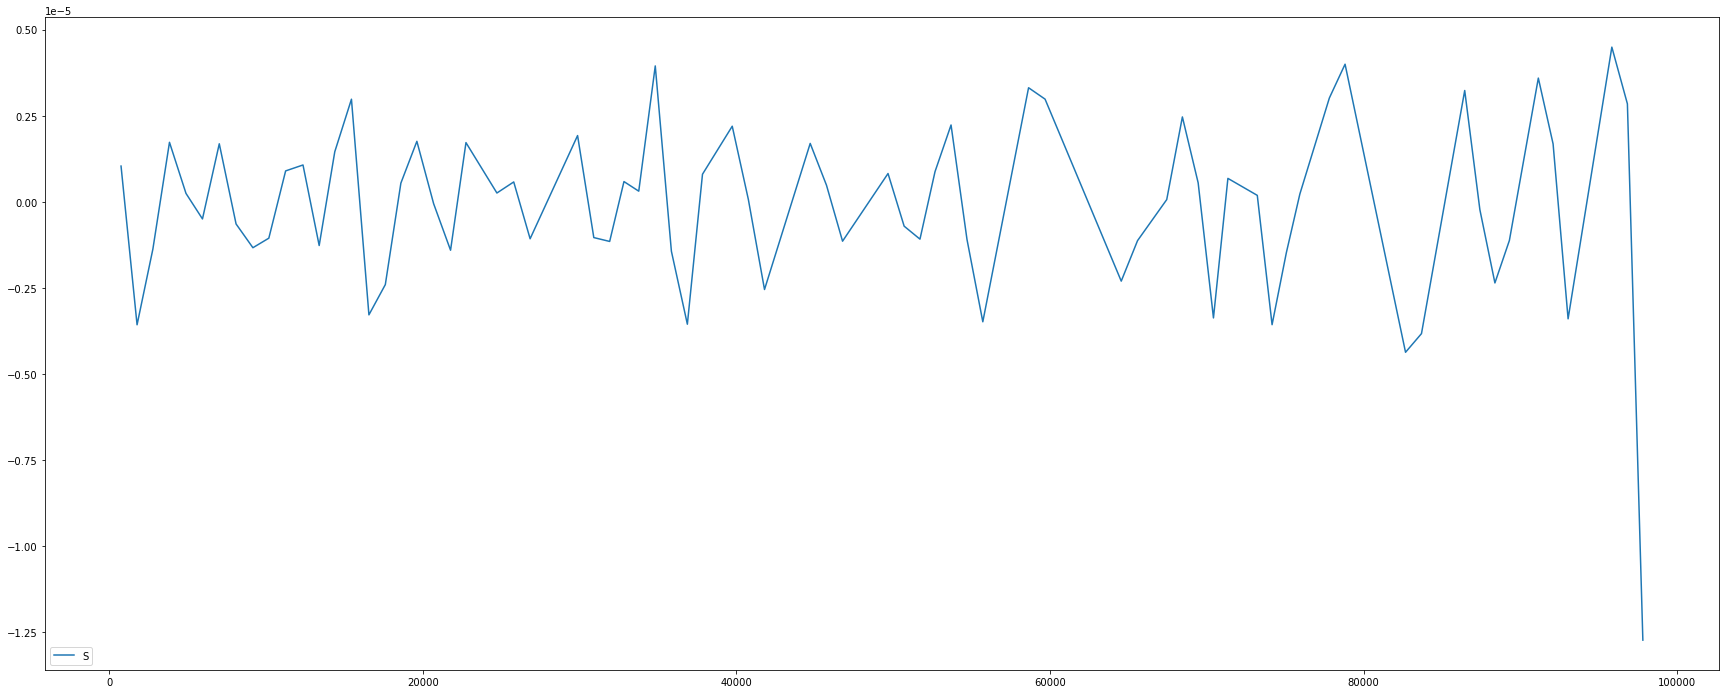

array([  757,  1779,  2788,  3846,  4899,  5950,  7022,  8093,  9166,
       10182, 11253, 12361, 13393, 14388, 15451, 16565, 17611, 18603,
       19623, 20691, 21771, 22754, 24727, 25800, 26845, 29872, 30907,
       31918, 32830, 33773, 34826, 35855, 36873, 37838, 39735, 40763,
       41793, 44707, 45746, 46770, 49670, 50698, 51707, 52667, 53689,
       54706, 55715, 58633, 59685, 64543, 65583, 67444, 68442, 69448,
       70424, 71345, 73219, 74162, 75071, 75934, 77816, 78817, 82673,
       83690, 86447, 87414, 88373, 89296, 91142, 92083, 93040, 95830,
       96822, 97808])

In [119]:
xaxis = list(range(len(peaks))); 
cs = CubicSpline(peaks, peakdata)
plt.figure(figsize=(30,12))
plt.plot(peaks, cs(peaks, 1), label="S")
plt.legend(loc='lower left', ncol=2)
plt.show()
peaks

## Sending data to a thingspeak channel. 

In [191]:
import requests
r =requests.get('https://api.thingspeak.com/update?api_key=948QDPQ4NMFMHJAL&field1=0')

# FIR filter design for CMSIS-DSP function

In [ ]:
num_taps = 4 # number of coefficients (i.e. filter order + 1)
nyquist = N/2 # nyquist frequency for our sampling rate
norm_cut_off = 45 / nyquist # normalised cut off frequency (cutoff is 45Hz)

b = signal.firwin(4, norm_cut_off, window="hamming", pass_zero="lowpass")
b